데이터와 모델을 불러오는 중...
🏆 감지된 최우수 모델: Deep Learning (DNN)
🎯 최적 임계값 적용: 0.5500
분석 준비 완료.

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
📊 1. 모델 종합 리포트 (Deep Learning (DNN))
              precision    recall  f1-score   support

  잔존(Active)       0.89      0.84      0.87      1364
 이탈(Churned)       0.70      0.78      0.74       636

    accuracy                           0.82      2000
   macro avg       0.79      0.81      0.80      2000
weighted avg       0.83      0.82      0.82      2000


📊 2. 특성 중요도 (Permutation Importance)
계산 중...
DNN 모델은 특성 중요도를 Permutation Importance로 측정하기 어렵습니다. 시각화 섹션을 건너뜀.

📊 3. 혼동 행렬 (Confusion Matrix)


<Figure size 600x600 with 0 Axes>

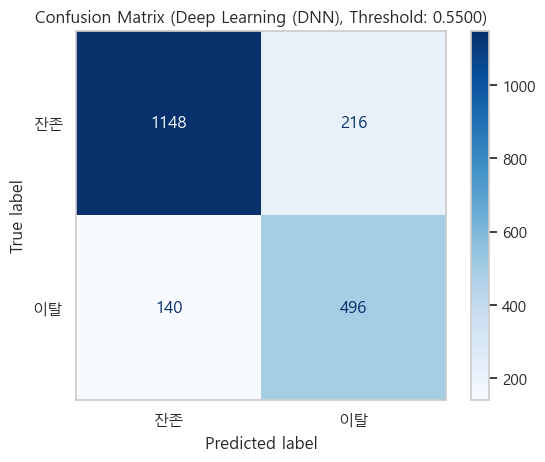


📊 4. ROC Curve & AUC


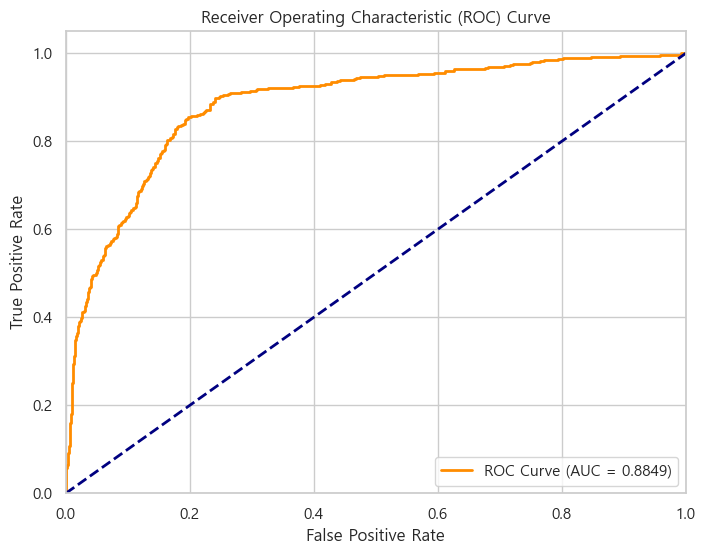

AUC 점수: 0.8849

분석 완료.


In [10]:
import pandas as pd
import numpy as np
import joblib
import json
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, classification_report

# 경고 메시지 무시
warnings.filterwarnings('ignore')

# 시각화 스타일 설정
sns.set_theme(style="whitegrid")
plt.rcParams['font.family'] = 'Malgun Gothic' 
plt.rcParams['axes.unicode_minus'] = False

# 1. 데이터 및 모델 로드
print("데이터와 모델을 불러오는 중...")

df = pd.read_csv('../data/spotify_churn_dataset.csv') 

# Feature Engineering (학습 때와 동일하게 원본 데이터에 적용)
df['ad_burden'] = df['ads_listened_per_week'] / (df['listening_time'] + 1)
df['satisfaction_score'] = df['songs_played_per_day'] * (1 - df['skip_rate'])
df['time_per_song'] = df['listening_time'] / (df['songs_played_per_day'] + 1)

if 'user_id' in df.columns:
    df = df.drop(columns=['user_id'])

X = df.drop(columns=['is_churned'])
y = df['is_churned']

# 테스트 데이터 분리
_, X_test, _, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


try:
    dl_model = tf.keras.models.load_model('../models/spotify_dl_model.h5')
    dl_preprocessor = joblib.load('../models/dl_preprocessor.pkl')
except Exception as e:
    print(f"모델 로드 오류: {e}")
    raise


# 2. 최적의 임계값(Threshold) 자동 로드
threshold = 0.5
winner_model_name = "Unknown Model"
max_f1 = -1

try:
    with open('../data/model_metrics.json', 'r') as f:
        metrics = json.load(f)
    
    for name, scores in metrics.items():
        if 'F1-Score' in scores and 'Best Threshold' in scores:
             if scores['F1-Score'] > max_f1:
                max_f1 = scores['F1-Score']
                threshold = scores['Best Threshold']
                winner_model_name = name
            
    print(f"🏆 감지된 최우수 모델: {winner_model_name}")
    print(f"🎯 최적 임계값 적용: {threshold:.4f}")

except FileNotFoundError:
    print("⚠️ model_metrics.json 파일을 찾지 못해 기본값(0.5)을 사용합니다.")

print("분석 준비 완료.\n")

# 3. 예측 및 평가
# [수정] DNN 모델 예측 로직
# 테스트 데이터 전처리 (DNN 모델에 맞게 스케일링/인코딩)
X_test_scaled = dl_preprocessor.transform(X_test)

# Keras model은 .predict()를 사용합니다.
y_pred_proba = dl_model.predict(X_test_scaled).flatten() 
y_pred_custom = (y_pred_proba >= threshold).astype(int)

print("="*50)
print(f"📊 1. 모델 종합 리포트 ({winner_model_name})")
print("="*50)
print(classification_report(y_test, y_pred_custom, target_names=['잔존(Active)', '이탈(Churned)']))


print("\n"+"="*50)
print("📊 2. 특성 중요도 (Permutation Importance)")
print("="*50)
print("계산 중...")
print("DNN 모델은 특성 중요도를 Permutation Importance로 측정하기 어렵습니다. 시각화 섹션을 건너뜀.")

print("\n"+"="*50)
print("📊 3. 혼동 행렬 (Confusion Matrix)")
print("="*50)
cm = confusion_matrix(y_test, y_pred_custom)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['잔존', '이탈'])

plt.figure(figsize=(6, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title(f'Confusion Matrix ({winner_model_name}, Threshold: {threshold:.4f})')
plt.grid(False)
plt.show() 


print("\n"+"="*50)
print("📊 4. ROC Curve & AUC")
print("="*50)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show() 

print(f"AUC 점수: {roc_auc:.4f}")
print("\n분석 완료.")